# Weekly assignment 5

## Read before you start

* Provide clear and complete answers in code blocks or markdown. You may add as many as you need.
* Always motivate your answers. This can be done in markdown cells, or in comments in code.
* Submit your results via Brightspace. Use the following filename convention: ``StudentName1_snumber1_StudentName2_snumber2_Assignment5.ipynb``.
* Make sure you submit a fully executed version of the notebook file. The teaching assistants will not run/debug your code during grading.
* Questions? Ask them during the workgroups, or see Brightspace for instructions on how to proceed.

__IMPORTANT__

This submission requires some images (plots or diagrams). Make sure your figures are actually embedded in the notebook
file, and do not reference something local on your machine!

In [ ]:
!apt install jags
!pip install pyjags

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  jags
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,644 kB of archives.
After this operation, 3,492 kB of additional disk space will be used.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ jags 4.3.2-1.2204.0 [1,644 kB]
Fetched 1,644 kB in 0s (4,873 kB/s)
Selecting previously unselected package jags.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../jags_4.3.2-1.2204.0_amd64.deb ...
Unpacking jags (4.3.2-1.2204.0) ...
Setting up jags (4.3.2-1.2204.0) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyjags as pj

print('Using PyJAGS v{:s}'.format(pj.__version__))

plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=12)       # legend fontsize
plt.rc('figure', titlesize=30)      # fontsize of the figure title

Using PyJAGS v1.3.8


# Understanding the gravity of the situation

A large physics consortium consisting of $M=20$ labs from all around the world have come together to once and for all determine the true value of the Earth's gravity $g$ (which we generally think of as $g=9.81m/s^2$).

However, the different labs use different techniques to measure $g$, each with their own biases and variances. They therefore need a hierarchical Bayesian model to integrate all their observations and try and find the best possible estimate. At the same time, such a model can inform us about how reliable the observations of different labs are.

Of course, you are the consultant with the task to construct and apply this model.

## Data

First of all, the data. To make things easy, each lab performs $N=10$ observations, which are indicated by $x_{ij}$; this shows observation $j$ for lab $i$.

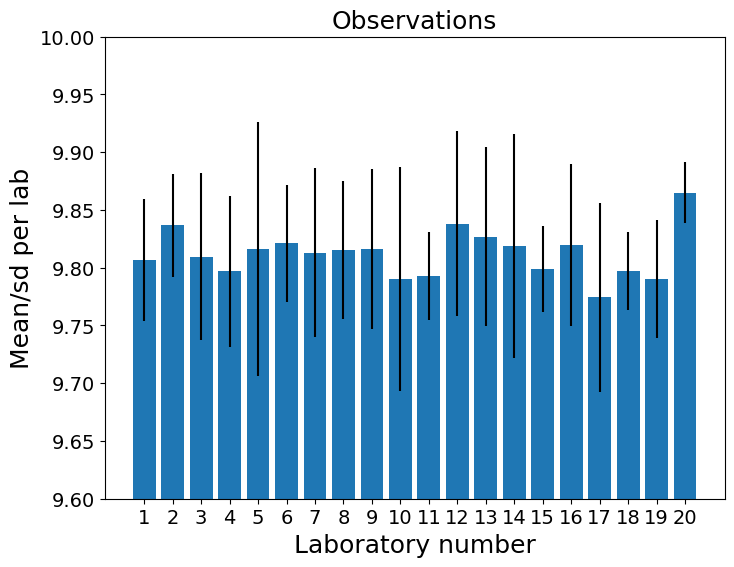

In [ ]:
x = np.loadtxt('gravity_data.csv', delimiter=',')
M, N = x.shape

plt.figure(figsize=(8, 6))
plt.bar(np.arange(M)+1, np.mean(x, axis=1), yerr=np.std(x, axis=1))
plt.xticks(np.arange(M)+1)
plt.ylim([9.6, 10.0])
plt.xlabel('Laboratory number')
plt.ylabel('Mean/sd per lab')
plt.title('Observations');

Some labs stand out. For example, the last lab seems to be biased towards larger estimates of $g$. This bias is very consistent; its variability is small. Probably, something went wrong with the machinery here.

1. How could hierarchical Bayesian modelling help with this issue?

Hierarchical Bayesian modeling can address the last lab's bias by estimating lab-specific effects while pooling information across all labs. This approach distinguishes between variability due to measurement processes and the underlying true value of gravity. By accounting for lab-specific biases, it yields a more accurate estimate of the true parameter, while allowing for uncertainty in each lab's measurements.

## The model

We will now start constructing the hierarchical Bayesian model step by step.

At the first level of the model, we need to combine the $N$ observations of each single lab $i$ to get the estimate of that lab, $\theta_i$, as well as to learn the standard deviation of the observations of that lab, $\sigma_i$. To do so, we must define the likelihoods $p(x_{ij} \mid \theta_i, \sigma_i)$.

2. What is a sensible distribution to model $p(x_{ij} \mid \theta_i, \sigma_i)$ with? Motivate your choice.

A sensible distribution to the model is the Gaussian distribution. It reflects the assumption that individual lab estimates of gravity, are likely to vary around a true global average. (central limit theorem).

The parameters $\theta_i$ represent the best estimates for $g$ for each individual lab. However, in hierarchical Bayesian modelling, we are interested in not only effects per lab, but particularly in the 'global' effect that we estimate based on the data for all $M$ labs.

To do this, we need a prior $p(\theta_i \mid \ldots)$. The parameters of this prior represent the __global__ estimate $\mu_\theta$, and its __standard deviation__ $\sigma_\theta$.

3. What is a sensible distribution for $p(\theta_i \mid \mu_\theta, \sigma_\theta)$?

A sensible distribution for p(θi∣μθ,σθ)  is the gaussian distribution, as it reflects the assumption that individual lab estimates of gravity, are likely to vary around a true global average. The gaussian distribution is also conjugacy with the gaussian likelihood.

Since we actually want to __know__ the global estimate and variability between the labs, we need to learn $\mu_\theta$ and $\sigma_\theta$ (if we did not, we wouldn't have a hierarchical model). This means these parameters too need to be specified a prior. The parameters of _these_ priors are hyperparameters that we will set manually.

4. Which prior distributions make sense for $\mu_\theta$ and which for $\sigma_\theta$, and why?

For μθ we want a prior that reflects the well established gravity value of 9,81, a gaussian distribution that has a big peak at this value and barely any variance would show a strong believe in this value. For σθ (the standard deviation) we could take the inverse-gamma distribution since the standard deviation has to have a value of > 0.  


5. Repeat the question above for $\sigma_i$, the variance of the measurements of lab $i$. What is a sensible prior here?

__Note__: Although we need a prior on $\sigma_i$ in order to learn it, our main interest is in $\mu_\theta$ and the individual distributions over $\theta_i$. Because of this, you can simply use the same prior for all $\sigma_i$, but you do not have to bother with a 'global' estimate for $\sigma$.

Here we could again take the inverse-gamma distribution. Since variance should again be > 0 and it is the conjugate prior of the variance of a gaussian distribution.

6. With your choices as above, write down the corresponding generative model using the $\sim$ notation. Be precise about indices (e.g., the subscripts $i$).

x_ij ~ Gaussian(θ_i, σ_i) <br>
θ_i ~ Gaussian(μ_g, σ_g) <br>
μ_g ~ Gaussian(mean, std) <br>
σ^2_g ~ Inverse_Gamma(shape, scale) <br>
σ^2_i ~ Inverse_Gamma(shape, scale)

7. Draw the corresponding graphical model using plate notation. Pay attention to: which variable is observed (data or hyperparameter), which is latent (these we want to learn), and to repetition.

Uploaded with the ipynb, was not allowed to upload 2 files so i hope the image is correct uploaded this way:
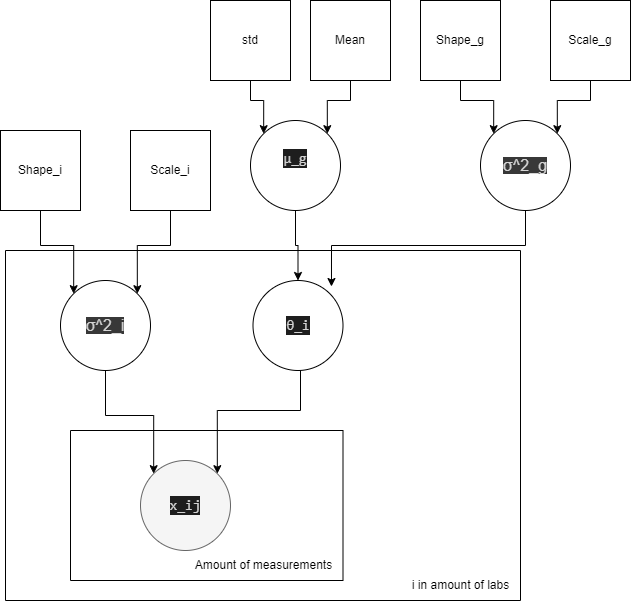

## JAGS

8. Now it is finally time to implement the model in JAGS! Use the code block below and run your model using the provided data above. Make sure to learn all the relevant parameters: $\theta_i$, $\sigma_i$, $\mu_\theta$ and $\tau_\theta$.

__Note__: If you are using Gaussian distributions, remember that JAGS uses `dnorm(mu, tau)` where `tau <- 1/sigma^2`. We call $\tau$ the precision, $\sigma$ the standard deviation and $\sigma^2$ the variance. In the end, they all cover how wide the distribution is.

In [ ]:
%%time

jags_model = '''
model {
    # Prior
    mu_g ~ dnorm(9.81, precision)
    tau_g ~ dgamma(shape, scale)

    # Likelihood
    for (i in 1:M) {
        theta[i] ~ dnorm(mu_g, tau_g)
        tau[i] ~ dgamma(shape, scale)
        for (j in 1:N) {
            x[i, j] ~ dnorm(theta[i], tau[i])
        }
    }
}
'''

data = dict(x=x, M=M, N=N, shape=0.1, scale=0.1, precision=0.0001)

# How long we sample
num_iter = 60_000
# How many distinct sampling runs
num_chains = 4

model = pj.Model(jags_model, data=data, chains=num_chains)
samples = model.sample(num_iter, vars=['theta', 'tau', 'mu_g', 'tau_g'])

sampling: iterations 240000 of 240000, elapsed 0:00:03, remaining 0:00:00
CPU times: user 3.08 s, sys: 297 ms, total: 3.38 s
Wall time: 3.38 s


## Visualizing the output

To visualize the output of your MCMC approximated posterior, you can use the `ridge_plot` code section below. It generates a ridge plot similar to the ones used in Lecture 5. It takes the following three arguments:

- `theta_samples`: an $M\times T \times C$ array, where $T$ is the number of iterations (`num_iter`), and $C$ is the number of chains (`num_chains`), containing all $\theta_i$ samples
- `mu_samples`: an $1\times T\times C$ array, containing all $\mu_\theta$ samples.
- `xlimits`: a tuple of values that give us the left and right limits of the horizontal axis; just for visual scaling.

9. Generate a ridge plot for the output of your model. In addition, add code that shows the maximum likelhood estimate (MLE) for each lab ($\hat{\theta}_i = \frac{1}{N}\sum_{j=1}^N x_{ij}$) as a red vertical line (you can use the `axvline` function) as well as the 'ground truth' ($g=9.81$).

<ipython-input-40-f02f2c822ec9>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('magma')


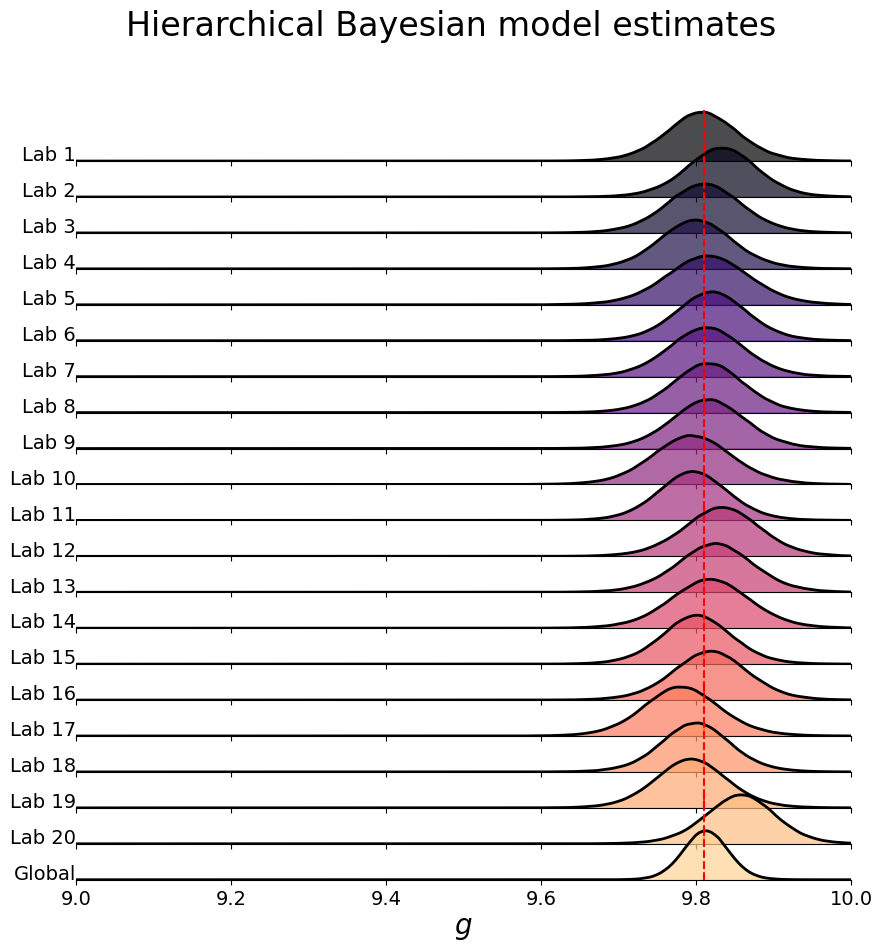

In [ ]:
import matplotlib.gridspec as grid_spec
from scipy.stats import gaussian_kde

def ridge_plot(theta_samples, mu_samples, xlimits):
    """Make a ridge-plot figure.

    This function makes a ridge plot. It consists of a number of visually
    overlapped smoothed histograms. It shows both the individual-level estimates
    as well as the hierarchical, global, estimate (last row).

    The dashed lines indicate the observed treatment effects, while the
    histograms show what our model estimates.

    Args:
        theta_samples: A numpy array of size J x num_samples x num_chains
        mu_samples: A numpy array of size 1 x num_samples x num_chains
        y: The observed treatment effects.
    """
    samples = np.concatenate([theta_samples, mu_samples], axis=0)
    colors = plt.cm.get_cmap('magma')
    J = samples.shape[0]
    gs = grid_spec.GridSpec(J, 1)
    fig = plt.figure(figsize=(10, 10))

    i = 0
    xmin, xmax = xlimits
    theta = np.linspace(xmin, xmax, num=200)

    ax_objs = []
    for i in range(J):
        pdf = gaussian_kde(samples[i, :, :].flatten())
        posterior = pdf(theta)

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].plot(theta, posterior, color='k', lw=2)
        ax_objs[-1].fill_between(theta, np.zeros_like(theta), posterior, alpha=0.7, color=colors(i/(J+1)))

        # setting uniform x and y lims
        ax_objs[-1].set_xlim(xmin, xmax)
        ax_objs[-1].set_ylim(bottom=0)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        if i == J-1:
            ax_objs[-1].set_xlabel(r'$\theta_i$', fontsize=20)
            ax_objs[-1].text(xmin, 0.001, 'Global', fontsize=14, ha="right")
        else:
            ax_objs[-1].set_xticklabels([])
            ax_objs[-1].text(xmin, 0.001, f'Lab {i+1}',fontsize=14, ha="right")

        spines = ["top", "right", "left"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
        ax_objs[-1].set_yticks([])

        i += 1

    ax_objs[-1].set_xlabel(r'$g$')
    for ax in ax_objs:
      ax.axvline(x=9.81, color='red', linestyle='--')
    gs.update(hspace=-0.3)
    plt.suptitle('Hierarchical Bayesian model estimates', fontsize=24)
    plt.show()

#
xlimits = 9, 10
ridge_plot(samples["theta"], samples["mu_g"], xlimits)

## Unexpected behaviour?

The result of the ridge plot should show the _shrinkage_ effect: for every lab, the distribution of $\theta_i$ should be nudged towards the _global_ mean, away from the MLE (and hopefully, _towards_ the true value of $g=9.81m/s^2$). This is the desired effect of hierarchical modelling; we now combine information from all the labs instead of treating them as completely independent.

However, maybe your figure does not show this behaviour! Instead, you might see one of two things, both having to do with the fact that we try to estimate the standard deviation across labs $\tau_\theta$. This is difficult, because the model can explain our observations in several ways:

- Either your estimates ignore the global mean and are pretty much centered at the MLE. This probably means $\sigma_\theta$ is too large (a.k.a. its distribution too wide).
- Alternatively, your estimates are (almost) identical to the global estimate. In this case, the distribution $\tau_\theta$ is probably too narrow: it explains the data by assuming all labs are almost perfect copies of each other, and that the variance in our data comes purely from the $\sigma_i$.

To solve this issue and actually see the desired effect, we can use very __un__informative priors for $\sigma_i$ and $\tau_\theta$. Try experimenting with uniform priors.

10. Tweak your hierarchical Bayesian model until you see the shrinkage effect. Describe the difference in your initial generative model and the one that you used in the end. If your model already shows the desired shrinking, you may skip this question (but please explain how you got that working first try...).

We tweaked our parameters until we got a seemingly good result.

Lastly, it is informative to create a similar ridge plot for all the parameters that represent variability in our model ($\sigma_i$ for each lab, as well as the variability between labs, $\sigma_\theta$).

11. Create another ridge plot showing the distributions over these parameters. This time, the global estimate probably has a different expectation (= mean) than the distributions for the individual labs. Why is this the case? Hint: what is the difference in interpretation of $\sigma_i$ and $\sigma_\theta$?

In [ ]:
#We do not understand this
xlimits = ?, ?
ridge_plot(?, ?, xlimits)

<ipython-input-34-3de1efe1d651>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('magma')
